<a href="https://colab.research.google.com/github/cyyeh/advanced-ml/blob/master/intro-to-dl/week2/notebooks/digits_classification_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set tf 2.x for colab
%tensorflow_version 2.x

TensorFlow 2.x selected.


# MNIST digits classification with TensorFlow

<img src="https://github.com/cyyeh/advanced-ml/blob/master/intro-to-dl/week2/notebooks/v2/images/mnist_sample.png?raw=1" style="width:30%">

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

We're using TF 2.1.0


# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(
    path='mnist.npz'
)

In [18]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

Normalize data and reserve the last 10000 training examples for validation

In [0]:
# normalize x
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

# we reserve the last 10000 training examples for validation
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

assert X_train.shape[0] == 50000, f"X_train size should be 50000, but we got {X_train.shape[0]}"
assert X_val.shape[0] == 10000, f"X_val size should be 10000, but we got {X_val.shape[0]}"
assert y_train.shape[0] == 50000, f"y_train size should be 50000, but we got {y_train.shape[0]}"
assert y_val.shape[0] == 10000, f"y_val size should be 10000, but we got {y_val.shape[0]}"

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


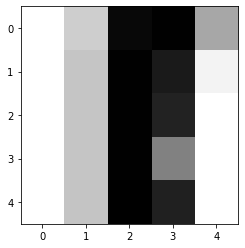

And the whole sample:


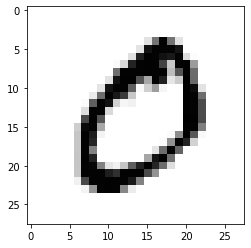

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [20]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [52]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [53]:
# one-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train, 10)
y_val_oh = tf.keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [0]:
EPOCHS = 40
BATCH_SIZE = 512
BUFFER_SIZE = 1024

In [0]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train_flat, y_train_oh))
    .shuffle(buffer_size=BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val_flat, y_val_oh))
    .batch(BATCH_SIZE)
)

# Method 1 For Building the Model

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(784,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Train for 98 steps, validate for 20 steps
Epoch 1/40
98/98 [==============================] - 1s 10ms/step - loss: 0.5360 - accuracy: 0.8594 - val_loss: 0.2476 - val_accuracy: 0.9317
Epoch 2/40
98/98 [==============================] - 1s 8ms/step - loss: 0.2316 - accuracy: 0.9352 - val_loss: 0.1893 - val_accuracy: 0.9496
Epoch 3/40
98/98 [==============================] - 1s 8ms/step - loss: 0.1760 - accuracy: 0.9503 - val_loss: 0.1550 - val_accuracy: 0.9587
Epoch 4/40
98/98 [==============================] - 1s 8ms/step - loss: 0.1418 - accuracy: 0.9590 - val_loss: 0.1364 - val_accuracy: 0.9634
Epoch 5/40
98/98 [==============================] - 1s 8ms/step - loss: 0.1182 - accuracy: 0.9663 - val_loss: 0.1217 - val_accuracy: 0.9673
Epoch 6/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0998 - accuracy: 0.9725 - val_loss: 0.1128 - val_accuracy: 0.9696
Epoch 7/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0852 - accuracy: 0.9764 - val_loss: 0.1048 

# Method 2 For Building the Model

In [0]:
from tensorflow import keras

class DigitsClassificationMLP(keras.models.Model):
  def __init__(self, units=256, activation='relu', **kwargs):
    super(DigitsClassificationMLP, self).__init__(**kwargs)
    self.hidden1 = keras.layers.Dense(units, activation=activation)
    self.hidden2 = keras.layers.Dense(units, activation=activation)
    self.main_outputs = keras.layers.Dense(10, activation='softmax')

  def call(self, inputs):
    hidden1_out = self.hidden1(inputs)
    hidden2_out = self.hidden2(hidden1_out)
    outputs = self.main_outputs(hidden2_out)
    return outputs

In [64]:
# initiate the model
model = DigitsClassificationMLP()

model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Train for 98 steps, validate for 20 steps
Epoch 1/40
98/98 [==============================] - 1s 11ms/step - loss: 0.4726 - accuracy: 0.8717 - val_loss: 0.1950 - val_accuracy: 0.9454
Epoch 2/40
98/98 [==============================] - 1s 7ms/step - loss: 0.1840 - accuracy: 0.9464 - val_loss: 0.1401 - val_accuracy: 0.9601
Epoch 3/40
98/98 [==============================] - 1s 7ms/step - loss: 0.1283 - accuracy: 0.9627 - val_loss: 0.1151 - val_accuracy: 0.9661
Epoch 4/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0944 - accuracy: 0.9733 - val_loss: 0.1018 - val_accuracy: 0.9703
Epoch 5/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0722 - accuracy: 0.9791 - val_loss: 0.0992 - val_accuracy: 0.9705
Epoch 6/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0565 - accuracy: 0.9835 - val_loss: 0.0937 - val_accuracy: 0.9736
Epoch 7/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0454 - accuracy: 0.9874 - val_loss: 0.0946 